In [54]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import TweetTokenizer

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score, f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix, roc_auc_score, recall_score, precision_score

In [55]:
path = "/home/hasan/Desktop/FYP-II/data/AnnotatedData3.csv"

def extract (path):
    fd= open(path,encoding="utf-8", errors='replace')
    df = pd.read_csv(fd)   
    defined=df['class'] != ("undefined")
    # #output dataframe without undeined
    df2=df[defined]
    defined1=df2['class'] !="Undefined"
    df4=df2[defined1]
    #replace no PI with no
    df3=df4.replace("No PI","no")
    #replace PI with yes
    final=df3.replace("PI","yes")
    
    replace_yes=final.replace("Yes","yes")
    final_df= replace_yes.replace("No","no")
    return final_df, df

final_data_frame, data_frame_undefined = extract(path)

final_data_frame.head()

,class,text
0,no,i'll buy the iphone x if it can get ac...
1,no,Some dude in FB selling the iPhone X 64 gb...
2,yes,Home dab emote man today and I get hopped on...
3,yes,Buy an iPhone X
4,no,I hate iOS 11. My iPhone 6+ works 10X slower...


In [56]:
data_clean = final_data_frame.copy()
data_clean['sentiment'] = data_clean['class'].apply(lambda x: 1 if x=='no' else 0)
data_clean['text_clean'] = data_clean['text'].apply(lambda x: BeautifulSoup(x, "lxml").text)
data_clean = data_clean.loc[:, ['text_clean', 'sentiment']]
data_clean.head()

,text_clean,sentiment
0,i'll buy the iphone x if it can get ac...,1
1,Some dude in FB selling the iPhone X 64 gb...,1
2,Home dab emote man today and I get hopped on...,0
3,Buy an iPhone X,0
4,I hate iOS 11. My iPhone 6+ works 10X slower...,1


In [57]:
train, test = train_test_split(data_clean, test_size=0.2, random_state=1)
X_train = train['text_clean'].values
X_test = test['text_clean'].values
y_train = train['sentiment']
y_test = test['sentiment']

In [58]:
def tokenize(text): 
    tknzr = TweetTokenizer()
    return tknzr.tokenize(text)

def stem(doc):
    return (stemmer.stem(w) for w in analyzer(doc))


en_stopwords = set(stopwords.words("english"))

vectorizer = CountVectorizer(
    analyzer="word",
    tokenizer=tokenize,
    lowercase=True,
    ngram_range=(1, 1),
    stop_words=en_stopwords,
)

In [59]:
kfolds = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

np.random.seed(1)

pipeline_svm = make_pipeline(vectorizer, 
                            SVC(probability=True, kernel="linear", class_weight="balanced"))

grid_svm = GridSearchCV(pipeline_svm,
                    param_grid = {'svc__C': [0.01, 0.1, 1]}, 
                    cv = kfolds,
                    scoring="roc_auc",
                    verbose=1,   
                    n_jobs=-1) 

grid_svm.fit(X_train, y_train)
grid_svm.score(X_test, y_test)

grid_svm.best_params_
grid_svm.best_score_

def report_results(model, X, y):
    pred_proba = model.predict_proba(X)[:, 1]
    pred = model.predict(X)        

    auc = roc_auc_score(y, pred_proba)
    acc = accuracy_score(y, pred)
    f1 = f1_score(y, pred)
    prec = precision_score(y, pred)
    rec = recall_score(y, pred)
    result = {'auc': auc, 'f1': f1, 'acc': acc, 'precision': prec, 'recall': rec}
    return result

report_results(grid_svm.best_estimator_, X_test, y_test)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    3.4s finished


{'auc': 0.7365402994584263,
 'f1': 0.5793103448275863,
 'acc': 0.698019801980198,
 'precision': 0.5833333333333334,
 'recall': 0.5753424657534246}

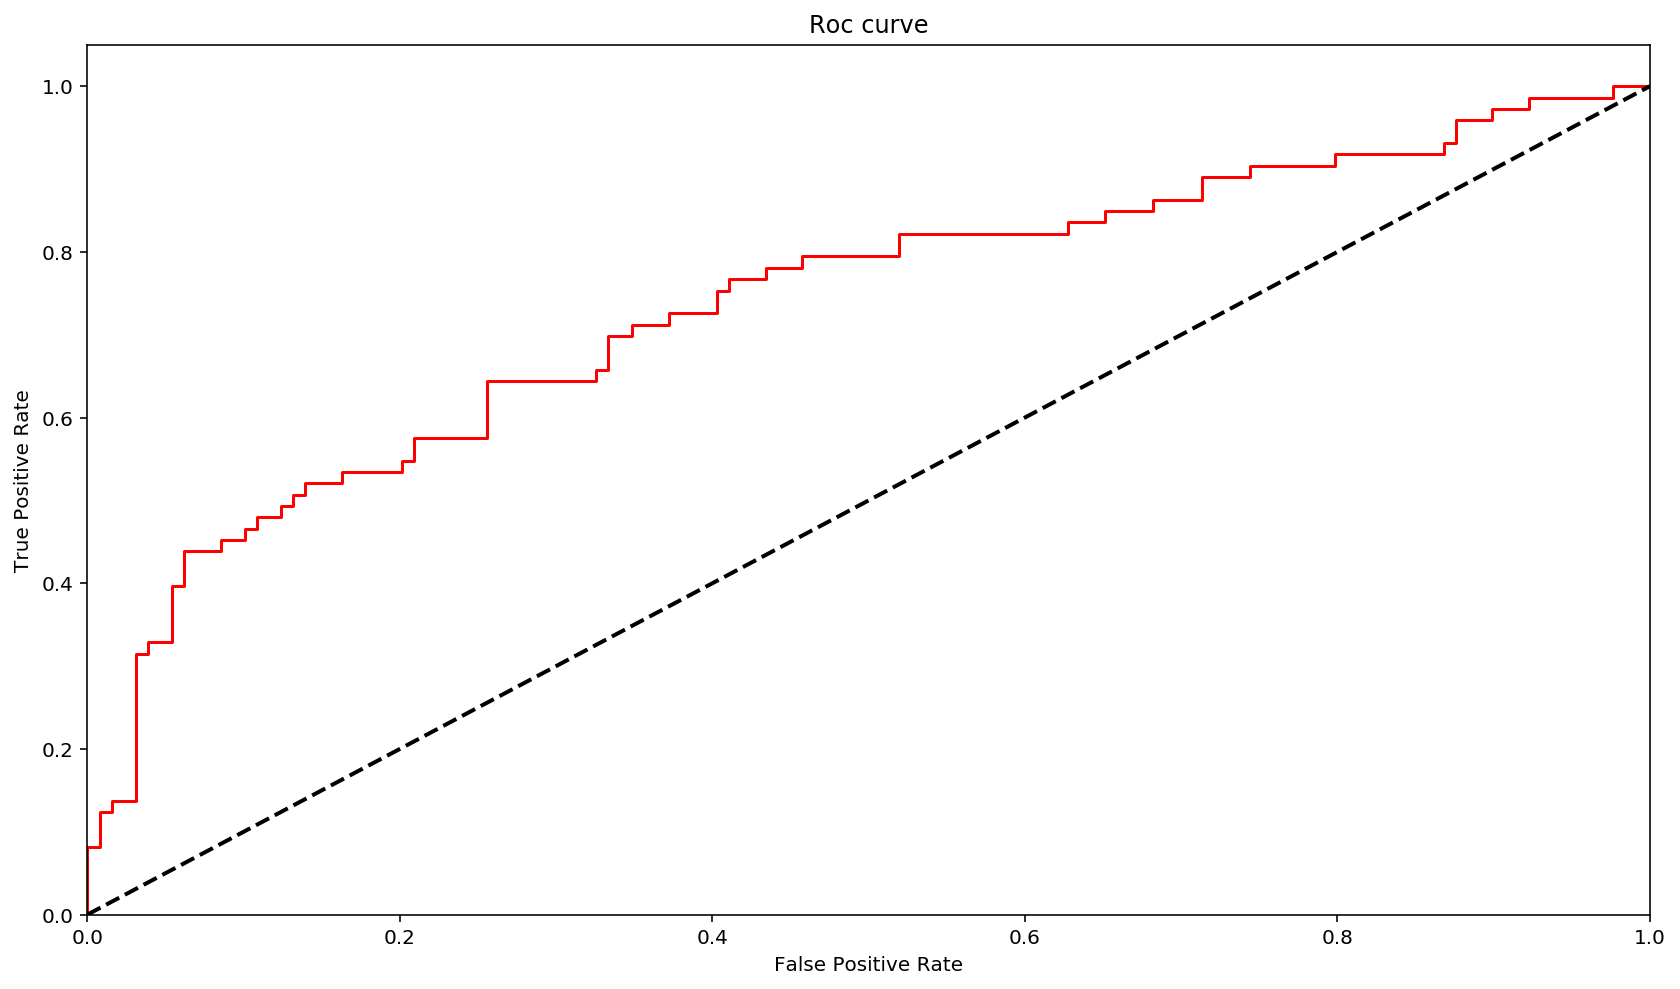

In [60]:
def get_roc_curve(model, X, y):
    pred_proba = model.predict_proba(X)[:, 1]
    fpr, tpr, _ = roc_curve(y, pred_proba)
    return fpr, tpr

roc_svm = get_roc_curve(grid_svm.best_estimator_, X_test, y_test)

fpr, tpr = roc_svm
plt.figure(figsize=(14,8))
plt.plot(fpr, tpr, color="red")
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Roc curve')
plt.show()

In [63]:
prediction_result = grid_svm.predict(["i wish i could find a good deal for the iphone X"])

print('purchase intention of tweet is: ')

if prediction_result == 1:
    print('no')
else: 
    print('yes')

[0]
purchase intention of tweet is: 
yes
